In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

from dataclasses import dataclass
from datetime import datetime
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = [8, 5]
sns.set_style('whitegrid', {'axes.labelcolor': '0', "text.color": '0', 'xtick.color': '0', 'ytick.color': '0', 'font.sans-serif': ['DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],})
sns.set_context('notebook', font_scale=1)

## NPHET IEMAG 2021-07-09 Model Scenario Projections vs Reported Data

This notebook compares the NPHET IEMAG 2021-07-09 model scenario projections with reported data, for 2021-07-01 to 2021-09-30. The projections are the mean values from the [Slides from the NPHET press briefing - Wednesday 14 July 2021](https://assets.gov.ie/154104/6a7feada-ea10-4f27-98b8-e8b5dc31771d.pdf).

Note:
* Daily data are currently not provided for deaths. The [(typically weekly) reported deaths to the ECDC](https://opendata.ecdc.europa.eu/covid19/nationalcasedeath_eueea_daily_ei/csv/data.csv) are used instead.

Slide 14 Summary:

<img src="figures/20210714_nphet_slides_summary_slide14.png" width="60%">

Slide 12 - Optimistic Scenario - Accelerated Vaccination (AV):

<img src="figures/20210714_nphet_slides_optimisticav_monthly.png" width="60%">



### Load the reported case data

This is a daily snapshot of the following from [Ireland's COVID-19 Data Hub](https://covid-19.geohive.ie/):
* [Covid-19 Daily Statistics](https://covid-19.geohive.ie/datasets/d8eb52d56273413b84b0187a4e9117be_0/explore?location=53.385818%2C-8.057012%2C7.64&showTable=true) ([CSV](https://opendata.arcgis.com/api/v3/datasets/d8eb52d56273413b84b0187a4e9117be_0/downloads/data?format=csv&spatialRefId=4326))
* [Acute Hospitals Confirmed Cases (New) and Admissions to ICU](https://covid-19.geohive.ie/pages/hospitals-icu--testing)
* [Data reported to the ECDC](https://opendata.ecdc.europa.eu/covid19/nationalcasedeath_eueea_daily_ei/csv/data.csv)

In [3]:
ecdcdf = pd.read_csv('./data/ecdcireland.csv', parse_dates=["Date"], date_parser=lambda x: datetime.strptime(x, "%d/%m/%Y"))
ecdcdf = ecdcdf[ecdcdf.Date>='2021-07-02']
ecdcdf.Cases = ecdcdf.Cases.cumsum()
ecdcdf.Deaths = ecdcdf.Deaths.cumsum()
# Shift back by one day to match locally reported data
ecdcdf.Date = ecdcdf.Date - pd.DateOffset(1)
ecdcdf['Scenario'] = 'Reported (ECDC)'

In [4]:
reporteddf = pd.read_csv('./data/reportedcases.csv', parse_dates=["Date"], date_parser=lambda x: datetime.strptime(x, "%Y-%m-%d"))
reporteddf = reporteddf[reporteddf.Date>='2021-07-01']

# Fewer cases are reported to the ECDC, assume this is related to denotifications, so this number may be used instead of locally reported number
# For now, report local number, but may change this
# As of 2021-07-29, 451 fewer cases were reported to the ECDC since 2021-07-01
reporteddf.Cases = reporteddf.Cases.cumsum()
#reporteddf.Cases = ecdcdf.Cases

reporteddf.HospitalCases = reporteddf.HospitalCases.cumsum()
reporteddf.IcuCases = reporteddf.IcuCases.cumsum()
reporteddf.Deaths = reporteddf.Deaths.cumsum()
reporteddf['Scenario'] = 'Reported'

In [5]:
geohivedf = pd.read_csv('./data/CovidStatisticsProfileHPSCIrelandOpenData.csv', parse_dates=["Date"], date_parser=lambda x: datetime.strptime(x, "%Y/%m/%d 00:00:00+00"))
geohivedf = geohivedf[geohivedf.Date>='2021-06-30'][['Date', 'ConfirmedCovidCases', 'TotalConfirmedCovidCases']]
geohivedf['RevisedCases']=geohivedf[['TotalConfirmedCovidCases']].diff().fillna(0).astype(int)
geohivedf['Cases'] = geohivedf.RevisedCases.cumsum()
geohivedf['Scenario'] = 'Reported (Total Geohive)'

### Scenario data 2021-07-01 to 2021-09-30, based on Table 1 and monthly tables above

In [6]:
scenario_dates = pd.date_range('2021-07-01', '2021-09-30')
july_dates = pd.date_range('2021-07-01', '2021-07-31')
august_dates = pd.date_range('2021-08-01', '2021-08-31')
september_dates = pd.date_range('2021-09-01', '2021-09-30')

@dataclass(frozen=True)
class Scenario:
    name: str
    mean_cases: int
    mean_hospital_cases: int
    mean_icu_cases: int
    mean_deaths: int
    dates: pd.DatetimeIndex
    color: int
  
# No monthly data yet for Central 1, Central 2, Pessimistic scenarios
scenarios = {name: Scenario(name, mean_cases, mean_hospital_cases, mean_icu_cases, mean_deaths, dates, color) for name, mean_cases, mean_hospital_cases, mean_icu_cases, mean_deaths, dates, color in 
    [
        ('Minimal change', 62000, 1185, 160, 210, scenario_dates, 0),
        ('Optimistic-AV (Jul)', 15000, 270, 35, 45, july_dates, 6),
        ('Optimistic-AV (Aug)', 15000+33000, 270+590, 35+75, 45+90, august_dates, 7),
        ('Optimistic-AV (Sep)', 105000, 1985, 260, 335, september_dates, 1),
        ('Optimistic-AV', 105000, 1985, 260, 335, scenario_dates, 1),
        #('Central 1 (Jul)', 10000, 180, 25, july_dates, 6),
        #('Central 1 (Aug)', 10000+46000, 180+790, 25+95, august_dates, 7),
        #('Central 1 (Sep)', 187000, 3490, 450, september_dates, 2),
        ('Central 1', 185000, 3455, 445, 550, scenario_dates, 2),
        #('Central 2 (Jul)', 16000, 280, 35, july_dates, 6),
        #('Central 2 (Aug)', 16000+106000, 280+1790, 35+210, august_dates, 7),
        #('Central 2 (Sep)', 408000, 7690, 985, september_dates, 3),
        ('Central 2', 379000, 6505, 915, 1150, scenario_dates, 3),
        #('Pessimistic (Jul)', 20000, 325, 40, july_dates, 6),
        #('Pessimistic (Aug)', 197000+23000, 325+3310, 40+385, august_dates, 7),
        #('Pessimistic (Sep)', 681000, 12985, 1685, september_dates, 4),
        ('Pessimistic', 566000, 10730, 1390, 1760, scenario_dates, 4),
    ]
}

scenariodf = pd.DataFrame({'Date': np.concatenate([x.dates for x in scenarios.values()]), 
                           'Scenario': np.concatenate([[x] * len(y.dates) for x, y in scenarios.items()]), 
                           'Cases': np.concatenate([[x.mean_cases] * len(x.dates) for x in scenarios.values()]),
                           'HospitalCases': np.concatenate([[x.mean_hospital_cases] * len(x.dates) for x in scenarios.values()]),
                           'IcuCases': np.concatenate([[x.mean_icu_cases] * len(x.dates) for x in scenarios.values()]),
                           'Deaths': np.concatenate([[x.mean_deaths] * len(x.dates) for x in scenarios.values()])})

### NPHET scenarios vs reported cases

In [7]:
default_palette = sns.color_palette()
generate_dashes = lambda plot_scenarios:[(3,2)] * len(plot_scenarios) + ['']
generate_palette = lambda plot_scenarios:[default_palette[scenarios[x].color] for x in plot_scenarios] + default_palette[5:6]

def plot_cases(plot_scenarios, model_title, case_type='Cases', y='Cases', ylabel='Cases', legend_loc='upper left', plot_scenario='all', plot_type='cases'):
    ax = sns.lineplot(data=pd.concat((scenariodf[scenariodf.Scenario.isin(plot_scenarios)], reporteddf), ignore_index=True), x='Date', y=y, hue='Scenario', style='Scenario', dashes=generate_dashes(plot_scenarios), palette=generate_palette(plot_scenarios))
    sns.despine(left=True, bottom=True)
    ax.set_title(f'NPHET IEMAG 2021-07-09 {model_title} Scenarios vs Reported {case_type} (Cumulative)')
    ax.set_ylabel(ylabel)
    plt.legend(loc=legend_loc)
    plt.xticks(rotation=30);
    if plot_scenario and plot_type:
        plt.savefig(f'./figures/nphet20210709_{plot_scenario}_scenarios_vs_reported_{plot_type}.png', bbox_inches='tight')
        
def plot_hospital_cases(plot_scenarios, model_title, legend_loc='upper left', plot_scenario='all'):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='Hospital Cases', 
               y='HospitalCases', 
               ylabel='New Hospital Cases',
               legend_loc=legend_loc, 
               plot_scenario=plot_scenario, 
               plot_type='hospital_cases')
    
def plot_icu_cases(plot_scenarios, model_title, legend_loc='upper left', plot_scenario='all'):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='ICU Cases', 
               y='IcuCases', 
               ylabel='New ICU Cases',
               legend_loc=legend_loc, 
               plot_scenario=plot_scenario, 
               plot_type='icu_cases')
    
def plot_deaths(plot_scenarios, model_title, legend_loc='upper left', plot_scenario='all'):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='Deaths', 
               y='Deaths', 
               ylabel='Deaths',
               legend_loc=legend_loc, 
               plot_scenario=plot_scenario,
               plot_type='deaths')

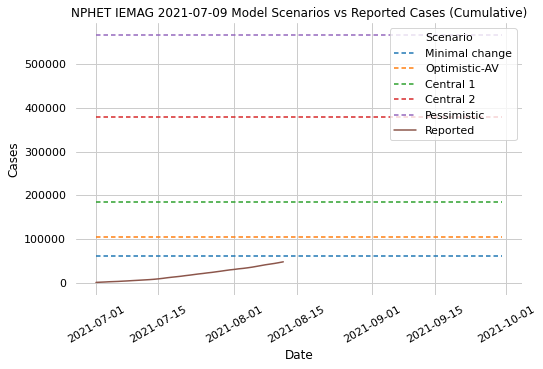

In [8]:
plot_cases(plot_scenarios=['Minimal change', 'Optimistic-AV', 'Central 1', 'Central 2', 'Pessimistic'], 
           model_title='Model', 
           legend_loc='upper right',
           plot_scenario='all')

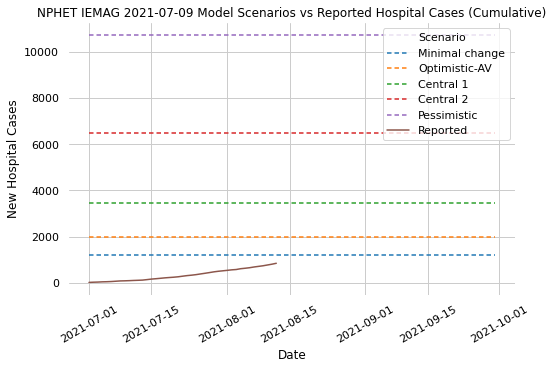

In [9]:
plot_hospital_cases(plot_scenarios=['Minimal change', 'Optimistic-AV', 'Central 1', 'Central 2', 'Pessimistic'], 
                    model_title='Model', 
                    legend_loc='upper right',
                    plot_scenario='all')

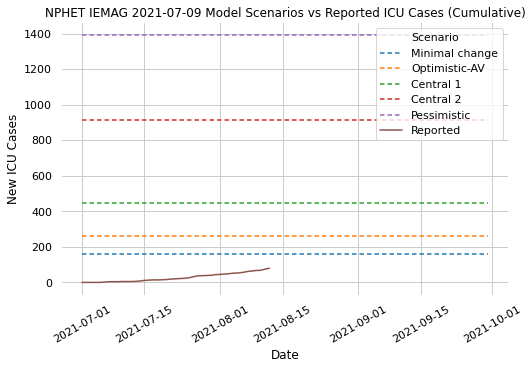

In [10]:
plot_icu_cases(plot_scenarios=['Minimal change', 'Optimistic-AV', 'Central 1', 'Central 2', 'Pessimistic'], 
               model_title='Model', 
               legend_loc='upper right',
               plot_scenario='all')

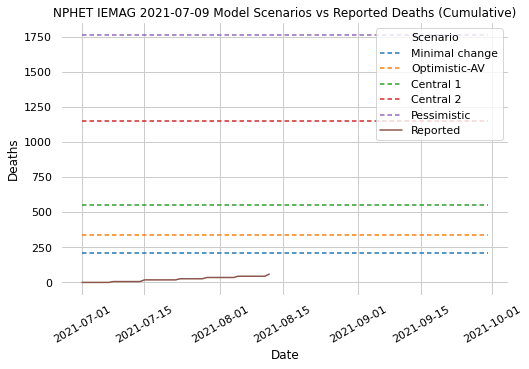

In [11]:
plot_deaths(plot_scenarios=['Minimal change', 'Optimistic-AV', 'Central 1', 'Central 2', 'Pessimistic'], 
            model_title='Model', 
            legend_loc='upper right',
            plot_scenario='all')

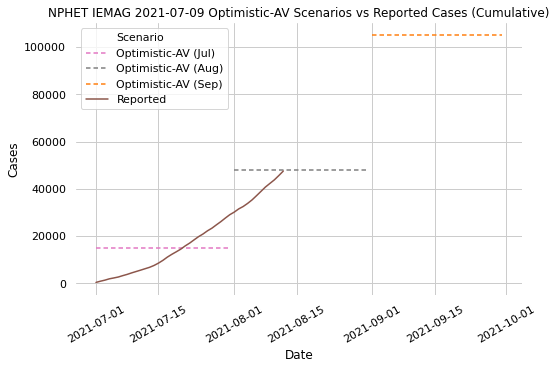

In [12]:
plot_cases(plot_scenarios=['Optimistic-AV (Jul)', 'Optimistic-AV (Aug)', 'Optimistic-AV (Sep)'], 
           model_title='Optimistic-AV',
           plot_scenario='optimisticav')

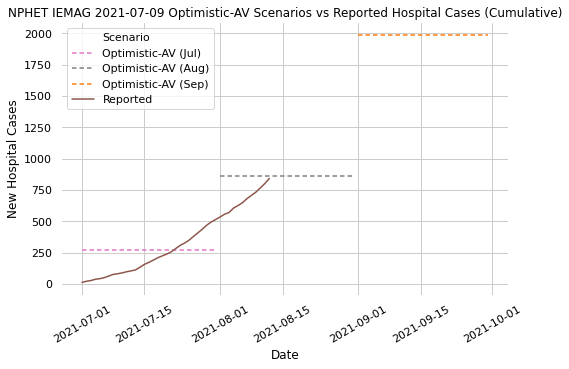

In [13]:
plot_hospital_cases(plot_scenarios=['Optimistic-AV (Jul)', 'Optimistic-AV (Aug)', 'Optimistic-AV (Sep)'], 
                    model_title='Optimistic-AV',
                    plot_scenario='optimisticav')

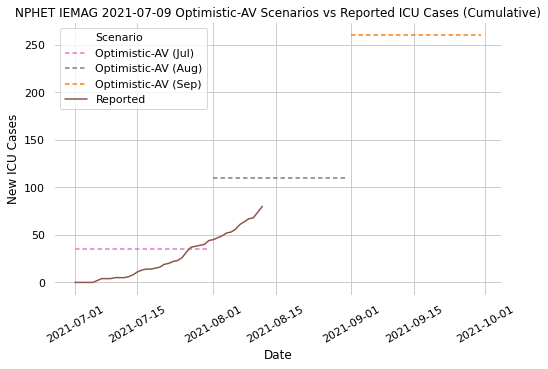

In [14]:
plot_icu_cases(plot_scenarios=['Optimistic-AV (Jul)', 'Optimistic-AV (Aug)', 'Optimistic-AV (Sep)'], 
               model_title='Optimistic-AV',
               plot_scenario='optimisticav')

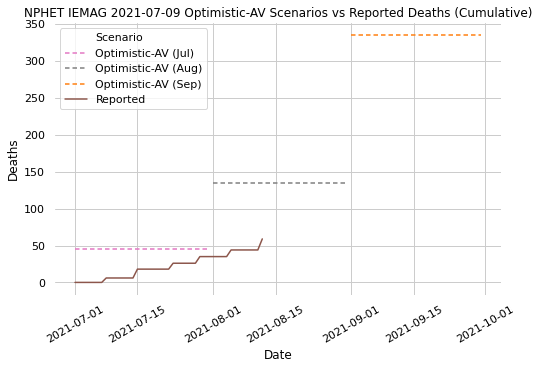

In [15]:
plot_deaths(plot_scenarios=['Optimistic-AV (Jul)', 'Optimistic-AV (Aug)', 'Optimistic-AV (Sep)'], 
            model_title='Optimistic-AV',
            plot_scenario='optimisticav')

In [16]:
#plot_cases(plot_scenarios=['Central 1 (Jul)', 'Central 1 (Aug)', 'Central 1 (Sep)'], 
#           model_title='Central 1',
#           filename='./figures/nphet20210709_central1_scenarios_vs_reported_cases.png')

In [17]:
#plot_hospital_cases(plot_scenarios=['Central 1 (Jul)', 'Central 1 (Aug)', 'Central 1 (Sep)'], 
#                    model_title='Central 1',
#                    filename='./figures/nphet20210709_central1_scenarios_vs_reported_hospital_cases.png')

In [18]:
#plot_icu_cases(plot_scenarios=['Central 1 (Jul)', 'Central 1 (Aug)', 'Central 1 (Sep)'], 
#               model_title='Central 1',
#               filename='./figures/nphet20210709_central1_scenarios_vs_reported_icu_cases.png')

In [19]:
#plot_cases(plot_scenarios=['Central 2 (Jul)', 'Central 2 (Aug)', 'Central 2 (Sep)'], 
#           model_title='Central 2',
#           filename='./figures/nphet20210709_central2_scenarios_vs_reported_cases.png')

In [20]:
#plot_hospital_cases(plot_scenarios=['Central 2 (Jul)', 'Central 2 (Aug)', 'Central 2 (Sep)'], 
#                    model_title='Central 2',
#                    filename='./figures/nphet20210709_central2_scenarios_vs_reported_hospital_cases.png')

In [21]:
#plot_icu_cases(plot_scenarios=['Central 2 (Jul)', 'Central 2 (Aug)', 'Central 2 (Sep)'], 
#               model_title='Central 2',
#               filename='./figures/nphet20210709_central2_scenarios_vs_reported_icu_cases.png')

In [22]:
#plot_cases(plot_scenarios=['Pessimistic (Jul)', 'Pessimistic (Aug)', 'Pessimistic (Sep)'], 
#           model_title='Pessimistic',
#           filename='./figures/nphet20210709_pessimistic_scenarios_vs_reported_cases.png')

In [23]:
#plot_hospital_cases(plot_scenarios=['Pessimistic (Jul)', 'Pessimistic (Aug)', 'Pessimistic (Sep)'], 
#                    model_title='Pessimistic',
#                    filename='./figures/nphet20210709_pessimistic_scenarios_vs_reported_hospital_cases.png')

In [24]:
#plot_icu_cases(plot_scenarios=['Pessimistic (Jul)', 'Pessimistic (Aug)', 'Pessimistic (Sep)'], 
#               model_title='Pessimistic',
#               filename='./figures/nphet20210709_pessimistic_scenarios_vs_reported_icu_cases.png')

### Generate current cases/hospitalisation/ICU summaries

In [25]:
def generate_summary(reported_column, scenario_cases, title):
    columndf = reporteddf[['Date', reported_column]].dropna()
    num_reported_days = len(columndf)
    scenario_length = len(scenario_dates)
    cases_current_row = columndf.iloc[-1]
    cases_current = int(cases_current_row[reported_column])
    cases_previous = int(columndf.iloc[-2][reported_column])
    new_cases = cases_current - cases_previous
    scenario_status = {}
    print(f"""NPHET IEMAG 2021-07-09 Model Scenarios vs Reported {title}

({datetime.strftime(cases_current_row.Date, "%A %Y-%m-%d")})

- Reported Total: {cases_current} (+{new_cases})
- % Scenario Duration ({len(scenario_dates)} days): {num_reported_days*100/scenario_length:.1f}%""")

    for scenario in ['Optimistic-AV (Aug)', 'Optimistic-AV (Sep)']:
        mean_cases = getattr(scenarios[scenario], scenario_cases)
        cases_current_perc = cases_current*100/mean_cases
        scenario_status[scenario] = {
            'cases_current_perc': cases_current_perc,
            'mean_daily_required_cases': (mean_cases - cases_current)/(scenario_length - num_reported_days)
        }
        print(f'- % {scenario} Scenario Total: {cases_current_perc:.1f}% (+{new_cases*100/mean_cases:.1f}%)')
    return scenario_status

In [26]:
cases_status = generate_summary('Cases', 'mean_cases', 'Cases')

NPHET IEMAG 2021-07-09 Model Scenarios vs Reported Cases

(Thursday 2021-08-12)

- Reported Total: 47566 (+1903)
- % Scenario Duration (92 days): 46.7%
- % Optimistic-AV (Aug) Scenario Total: 99.1% (+4.0%)
- % Optimistic-AV (Sep) Scenario Total: 45.3% (+1.8%)


In [27]:
hosp_status = generate_summary('HospitalCases', 'mean_hospital_cases', 'New HOSPITAL Cases')

NPHET IEMAG 2021-07-09 Model Scenarios vs Reported New HOSPITAL Cases

(Thursday 2021-08-12)

- Reported Total: 842 (+41)
- % Scenario Duration (92 days): 46.7%
- % Optimistic-AV (Aug) Scenario Total: 97.9% (+4.8%)
- % Optimistic-AV (Sep) Scenario Total: 42.4% (+2.1%)


In [28]:
icu_status = generate_summary('IcuCases', 'mean_icu_cases', 'New ICU Cases')

NPHET IEMAG 2021-07-09 Model Scenarios vs Reported New ICU Cases

(Thursday 2021-08-12)

- Reported Total: 80 (+6)
- % Scenario Duration (92 days): 46.7%
- % Optimistic-AV (Aug) Scenario Total: 72.7% (+5.5%)
- % Optimistic-AV (Sep) Scenario Total: 30.8% (+2.3%)


In [29]:
death_status = generate_summary('Deaths', 'mean_deaths', 'Deaths')

NPHET IEMAG 2021-07-09 Model Scenarios vs Reported Deaths

(Thursday 2021-08-12)

- Reported Total: 59 (+15)
- % Scenario Duration (92 days): 46.7%
- % Optimistic-AV (Aug) Scenario Total: 43.7% (+11.1%)
- % Optimistic-AV (Sep) Scenario Total: 17.6% (+4.5%)


In [30]:
status_scenario = 'Optimistic-AV (Sep)'

print(f"""As of {datetime.strftime(reporteddf.iloc[-1].Date, "%Y-%m-%d")}, the following were reported for the Optimistic-AV scenario:

- {cases_status[status_scenario]['cases_current_perc']:.1f}% cases
- {hosp_status[status_scenario]['cases_current_perc']:.1f}% hospitalisation
- {icu_status[status_scenario]['cases_current_perc']:.1f}% ICU cases
- {death_status[status_scenario]['cases_current_perc']:.1f}% Deaths

Average daily numbers required until end Sept to reach the Optimistic-AV projections:

- {cases_status[status_scenario]['mean_daily_required_cases']:.0f} cases
- {hosp_status[status_scenario]['mean_daily_required_cases']:.0f} hosp
- {icu_status[status_scenario]['mean_daily_required_cases']:.0f} ICU
- {death_status[status_scenario]['mean_daily_required_cases']:.0f} deaths
""")

As of 2021-08-12, the following were reported for the Optimistic-AV scenario:

- 45.3% cases
- 42.4% hospitalisation
- 30.8% ICU cases
- 17.6% Deaths

Average daily numbers required until end Sept to reach the Optimistic-AV projections:

- 1172 cases
- 23 hosp
- 4 ICU
- 6 deaths



### A quick look at 7-day mean/95% CI new cases

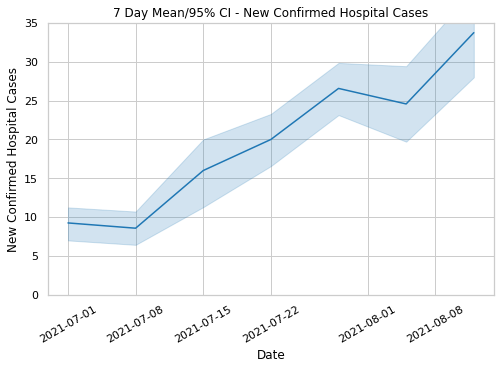

In [31]:
rdf=pd.read_csv('./data/reportedcases.csv', parse_dates=["Date"], date_parser=lambda x: datetime.strptime(x, "%Y-%m-%d"))
rdf.Date = rdf.Date.dt.round('7D')
ax=sns.lineplot(data=rdf, x='Date', y='HospitalCases')
ax.set_ylim((0,35))
ax.set_title('7 Day Mean/95% CI - New Confirmed Hospital Cases')
ax.set_ylabel('New Confirmed Hospital Cases')
plt.xticks(rotation=30);
plt.savefig(f'./figures/reported_hosp_7d_mean_ci95.png', bbox_inches='tight')

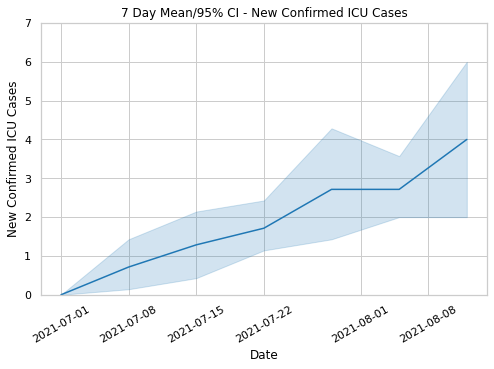

In [32]:
ax=sns.lineplot(data=rdf, x='Date', y='IcuCases')
ax.set_ylim((0,7))
ax.set_title('7 Day Mean/95% CI - New Confirmed ICU Cases')
ax.set_ylabel('New Confirmed ICU Cases')
plt.xticks(rotation=30);
plt.savefig(f'./figures/reported_icu_7d_mean_ci95.png', bbox_inches='tight')

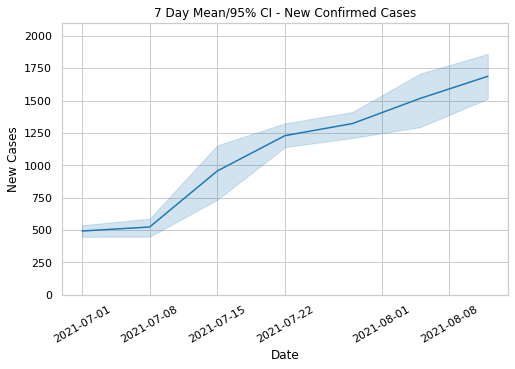

In [33]:
ax=sns.lineplot(data=rdf, x='Date', y='Cases')
ax.set_ylim((0,2100))
ax.set_title('7 Day Mean/95% CI - New Confirmed Cases')
ax.set_ylabel('New Cases')
plt.xticks(rotation=30);
plt.savefig(f'./figures/reported_cases_7d_mean_ci95.png', bbox_inches='tight')

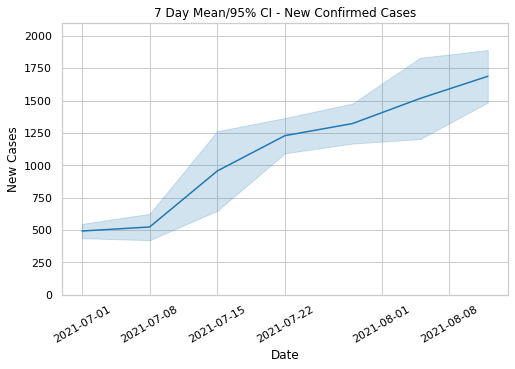

In [34]:
ax=sns.lineplot(data=rdf, x='Date', y='Cases', ci='sd')
ax.set_ylim((0,2100))
ax.set_title('7 Day Mean/95% CI - New Confirmed Cases')
ax.set_ylabel('New Cases')
plt.xticks(rotation=30);
#plt.savefig(f'./figures/reported_cases_7d_mean_ci95.png', bbox_inches='tight')

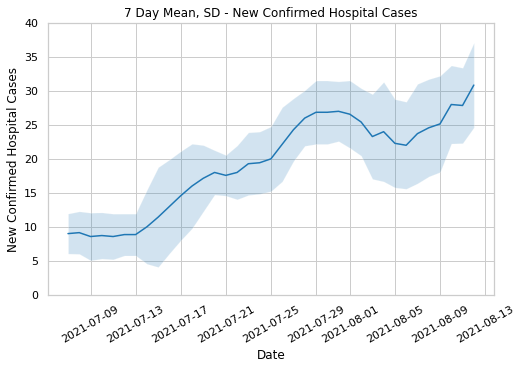

In [35]:
mdf=pd.read_csv('./data/reportedcases.csv', parse_dates=["Date"], date_parser=lambda x: datetime.strptime(x, "%Y-%m-%d"))
mdf['7dhosp']=mdf.HospitalCases.rolling(7).mean().dropna()
ax=sns.lineplot(data=mdf, x='Date', y='7dhosp')
ax.set_ylim((0,40))
ax.set_title('7 Day Mean, SD - New Confirmed Hospital Cases')
ax.set_ylabel('New Confirmed Hospital Cases')
hospstd = mdf.HospitalCases.rolling(7).std()
ax.fill_between(mdf.Date, mdf['7dhosp'] - hospstd, mdf['7dhosp'] + hospstd, alpha=0.2)
plt.xticks(rotation=30);
plt.savefig(f'./figures/reported_hosp_7d_mean_sd.png', bbox_inches='tight')

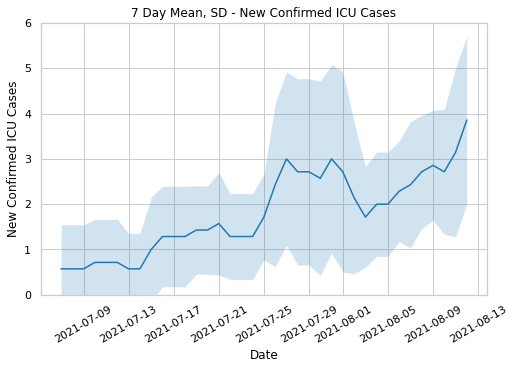

In [36]:
mdf['7dicu']=mdf.IcuCases.rolling(7).mean().dropna()
ax=sns.lineplot(data=mdf, x='Date', y='7dicu')
ax.set_ylim((0,6))
ax.set_title('7 Day Mean, SD - New Confirmed ICU Cases')
ax.set_ylabel('New Confirmed ICU Cases')
icustd = mdf.IcuCases.rolling(7).std()
ax.fill_between(mdf.Date, mdf['7dicu'] - icustd, mdf['7dicu'] + icustd, alpha=0.2)
plt.xticks(rotation=30);
plt.savefig(f'./figures/reported_icu_7d_mean_sd.png', bbox_inches='tight')

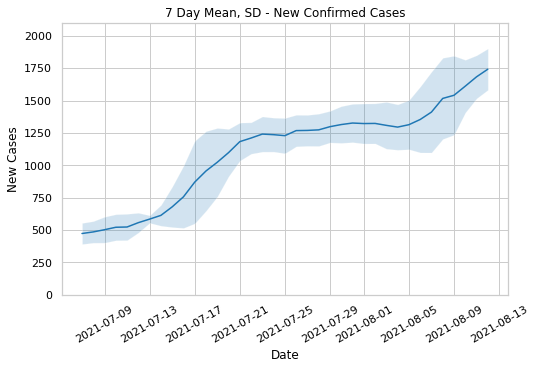

In [37]:
mdf['7dcases']=mdf.Cases.rolling(7).mean().dropna()
ax=sns.lineplot(data=mdf, x='Date', y='7dcases')
ax.set_ylim((0,2100))
ax.set_title('7 Day Mean, SD - New Confirmed Cases')
ax.set_ylabel('New Cases')
casesstd = mdf.Cases.rolling(7).std()
ax.fill_between(mdf.Date, mdf['7dcases'] - casesstd, mdf['7dcases'] + casesstd, alpha=0.2)
plt.xticks(rotation=30);
plt.savefig(f'./figures/reported_cases_7d_mean_sd.png', bbox_inches='tight')

### A quick look at the percentage of Confirmed Hospital Cases that are **non-admission**

Uses a daily snapshot of:

* [Covid-19 Acute Hospital Historic Summary](https://covid-19.geohive.ie/datasets/fe9bb23592ec4142a4f4c2c9bd32f749_0/explore?location=53.385818%2C-8.057012%2C7.64&showTable=true) ([CSV](https://opendata.arcgis.com/api/v3/datasets/fe9bb23592ec4142a4f4c2c9bd32f749_0/downloads/data?format=csv&spatialRefId=4326))

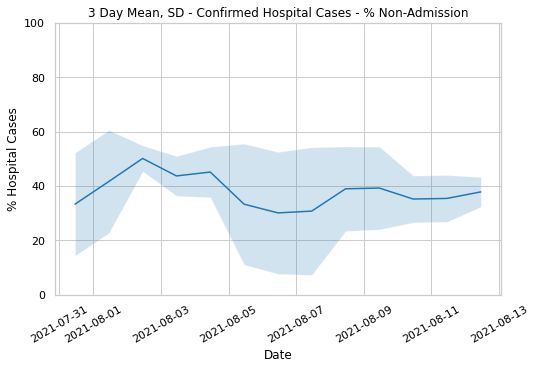

In [38]:
hdf=pd.read_csv('./data/Covid19AcuteHospitalHistoricSummaryOpenData.csv', parse_dates=["Date"], date_parser=lambda x: datetime.strptime(x, "%Y/%m/%d %H:00:00+00"))
hdf=hdf[hdf.Date>='2021-07-01'][['Date', 'SUM_no_new_admissions_covid19_p', 'SUM_number_of_new_covid_19_cases_co']].dropna()
hdf['perc_nonadmiss']=hdf[['SUM_no_new_admissions_covid19_p', 'SUM_number_of_new_covid_19_cases_co']].dropna().apply(lambda x:((x[1]-x[0])*100)/x[1], axis=1)
hdf['3dperc']=hdf.perc_nonadmiss.rolling(3).mean().dropna()
ax=sns.lineplot(data=hdf, x='Date', y='3dperc')
ax.set_ylim((0,100))
ax.set_title('3 Day Mean, SD - Confirmed Hospital Cases - % Non-Admission')
ax.set_ylabel('% Hospital Cases')
percstd = hdf.perc_nonadmiss.rolling(3).std()
ax.fill_between(hdf.Date, hdf['3dperc'] - percstd, hdf['3dperc'] +percstd, alpha=0.2)
plt.xticks(rotation=30);
#plt.savefig(f'./figures/reported_hosp_7d_mean_sd.png', bbox_inches='tight')

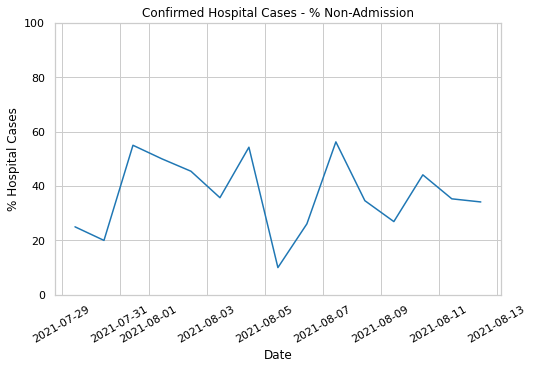

In [39]:
ax=sns.lineplot(data=hdf, x='Date', y='perc_nonadmiss')
ax.set_ylim((0,100))
ax.set_title('Confirmed Hospital Cases - % Non-Admission')
ax.set_ylabel('% Hospital Cases')
plt.xticks(rotation=30);
plt.savefig(f'./figures/reported_hosp_perc_nonadmiss.png', bbox_inches='tight')